In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from utils_fashion import fashion_mnist, plot_graphs, plot_fashion_mnist
import numpy as np

In [2]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=10000)

In [3]:
class Net (nn.Module):
    def __init__ (self, batchnorm = False, dropout = False, lr=1e-4, l2 = 0.0):
        super (Net, self).__init__ ()
        self.fc1 = nn.Linear (28 * 28, 512)
        self.fc2 = nn.Linear (512, 512)
        self.fc3 = nn.Linear (512, 10)
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bn = nn.BatchNorm1d (512)
        self.dropout = dropout
        self.optim = optim.Adam (self.parameters (), lr = lr, weight_decay = l2)
        
    def forward (self, x):
        x = x.view (-1, 28 * 28)
        x = torch.relu (self.fc1 (x))
        x = torch.relu (self.fc2 (x))
        x = torch.log_softmax (self.fc3 (x), dim = 1)
        return x
    
    def loss (self, output, target, **kwargs):
        self._loss = F.nll_loss (output, target, **kwargs)
        return self._loss

In [4]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [5]:
models = {'default': Net(False, False)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [7]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.314552
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 0.587341
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.444786
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.355168
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.354488
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.322054
Test set:
default: Loss: 0.4215	Accuracy: 8488.0/10000 (85%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.621316
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.338270
Train Epoch: 2 [20000/50000 (40%)]	Losses default: 0.404931
Train Epoch: 2 [30000/50000 (60%)]	Losses default: 0.400499
Train Epoch: 2 [40000/50000 (80%)]	Losses default: 0.384361
Train Epoch: 2 [50000/50000 (100%)]	Losses default: 0.397994
Test set:
default: Loss: 0.3714	Accuracy: 8646.0/10000 (86%)

Train Epoch: 3 [0/50000 (0%)]	Losses default: 0.314346
Train Epoch: 3 [10000/50000 (20%)]	Losses default: 0.302518
Train Epoch: 3 [20000/50000 (40%)]	Losses default

Train Epoch: 20 [40000/50000 (80%)]	Losses default: 0.089743
Train Epoch: 20 [50000/50000 (100%)]	Losses default: 0.111598
Test set:
default: Loss: 0.3154	Accuracy: 8987.0/10000 (90%)

Train Epoch: 21 [0/50000 (0%)]	Losses default: 0.131001
Train Epoch: 21 [10000/50000 (20%)]	Losses default: 0.126790
Train Epoch: 21 [20000/50000 (40%)]	Losses default: 0.119024
Train Epoch: 21 [30000/50000 (60%)]	Losses default: 0.207578
Train Epoch: 21 [40000/50000 (80%)]	Losses default: 0.103359
Train Epoch: 21 [50000/50000 (100%)]	Losses default: 0.124548
Test set:
default: Loss: 0.3334	Accuracy: 8914.0/10000 (89%)

Train Epoch: 22 [0/50000 (0%)]	Losses default: 0.134654
Train Epoch: 22 [10000/50000 (20%)]	Losses default: 0.139996
Train Epoch: 22 [20000/50000 (40%)]	Losses default: 0.228953
Train Epoch: 22 [30000/50000 (60%)]	Losses default: 0.178034
Train Epoch: 22 [40000/50000 (80%)]	Losses default: 0.072127
Train Epoch: 22 [50000/50000 (100%)]	Losses default: 0.295573
Test set:
default: Loss: 0.33

Train Epoch: 40 [10000/50000 (20%)]	Losses default: 0.017492
Train Epoch: 40 [20000/50000 (40%)]	Losses default: 0.039400
Train Epoch: 40 [30000/50000 (60%)]	Losses default: 0.042027
Train Epoch: 40 [40000/50000 (80%)]	Losses default: 0.100433
Train Epoch: 40 [50000/50000 (100%)]	Losses default: 0.040470
Test set:
default: Loss: 0.4647	Accuracy: 8946.0/10000 (89%)

Train Epoch: 41 [0/50000 (0%)]	Losses default: 0.045923
Train Epoch: 41 [10000/50000 (20%)]	Losses default: 0.027490
Train Epoch: 41 [20000/50000 (40%)]	Losses default: 0.025705
Train Epoch: 41 [30000/50000 (60%)]	Losses default: 0.077930
Train Epoch: 41 [40000/50000 (80%)]	Losses default: 0.002364
Train Epoch: 41 [50000/50000 (100%)]	Losses default: 0.018136
Test set:
default: Loss: 0.4702	Accuracy: 8977.0/10000 (90%)

Train Epoch: 42 [0/50000 (0%)]	Losses default: 0.034837
Train Epoch: 42 [10000/50000 (20%)]	Losses default: 0.069922
Train Epoch: 42 [20000/50000 (40%)]	Losses default: 0.008817
Train Epoch: 42 [30000/50000 (

Train Epoch: 59 [40000/50000 (80%)]	Losses default: 0.025374
Train Epoch: 59 [50000/50000 (100%)]	Losses default: 0.008527
Test set:
default: Loss: 0.5859	Accuracy: 8987.0/10000 (90%)

Train Epoch: 60 [0/50000 (0%)]	Losses default: 0.001870
Train Epoch: 60 [10000/50000 (20%)]	Losses default: 0.014814
Train Epoch: 60 [20000/50000 (40%)]	Losses default: 0.003215
Train Epoch: 60 [30000/50000 (60%)]	Losses default: 0.000789
Train Epoch: 60 [40000/50000 (80%)]	Losses default: 0.002977
Train Epoch: 60 [50000/50000 (100%)]	Losses default: 0.045418
Test set:
default: Loss: 0.6177	Accuracy: 8942.0/10000 (89%)

Train Epoch: 61 [0/50000 (0%)]	Losses default: 0.004986
Train Epoch: 61 [10000/50000 (20%)]	Losses default: 0.037859
Train Epoch: 61 [20000/50000 (40%)]	Losses default: 0.068319
Train Epoch: 61 [30000/50000 (60%)]	Losses default: 0.040236
Train Epoch: 61 [40000/50000 (80%)]	Losses default: 0.001544
Train Epoch: 61 [50000/50000 (100%)]	Losses default: 0.011339
Test set:
default: Loss: 0.57

Train Epoch: 79 [10000/50000 (20%)]	Losses default: 0.004294
Train Epoch: 79 [20000/50000 (40%)]	Losses default: 0.001657
Train Epoch: 79 [30000/50000 (60%)]	Losses default: 0.036605
Train Epoch: 79 [40000/50000 (80%)]	Losses default: 0.012556
Train Epoch: 79 [50000/50000 (100%)]	Losses default: 0.000322
Test set:
default: Loss: 0.7021	Accuracy: 9001.0/10000 (90%)

Train Epoch: 80 [0/50000 (0%)]	Losses default: 0.002308
Train Epoch: 80 [10000/50000 (20%)]	Losses default: 0.003097
Train Epoch: 80 [20000/50000 (40%)]	Losses default: 0.005058
Train Epoch: 80 [30000/50000 (60%)]	Losses default: 0.027276
Train Epoch: 80 [40000/50000 (80%)]	Losses default: 0.015038
Train Epoch: 80 [50000/50000 (100%)]	Losses default: 0.004559
Test set:
default: Loss: 0.6864	Accuracy: 8992.0/10000 (90%)

Train Epoch: 81 [0/50000 (0%)]	Losses default: 0.024559
Train Epoch: 81 [10000/50000 (20%)]	Losses default: 0.000748
Train Epoch: 81 [20000/50000 (40%)]	Losses default: 0.006156
Train Epoch: 81 [30000/50000 (

Train Epoch: 98 [40000/50000 (80%)]	Losses default: 0.000065
Train Epoch: 98 [50000/50000 (100%)]	Losses default: 0.000559
Test set:
default: Loss: 0.7656	Accuracy: 9010.0/10000 (90%)

Train Epoch: 99 [0/50000 (0%)]	Losses default: 0.007654
Train Epoch: 99 [10000/50000 (20%)]	Losses default: 0.003990
Train Epoch: 99 [20000/50000 (40%)]	Losses default: 0.001267
Train Epoch: 99 [30000/50000 (60%)]	Losses default: 0.085121
Train Epoch: 99 [40000/50000 (80%)]	Losses default: 0.072742
Train Epoch: 99 [50000/50000 (100%)]	Losses default: 0.002786
Test set:
default: Loss: 0.7428	Accuracy: 9003.0/10000 (90%)

Train Epoch: 100 [0/50000 (0%)]	Losses default: 0.004648
Train Epoch: 100 [10000/50000 (20%)]	Losses default: 0.000815
Train Epoch: 100 [20000/50000 (40%)]	Losses default: 0.044223
Train Epoch: 100 [30000/50000 (60%)]	Losses default: 0.001415
Train Epoch: 100 [40000/50000 (80%)]	Losses default: 0.004889
Train Epoch: 100 [50000/50000 (100%)]	Losses default: 0.035846
Test set:
default: Loss

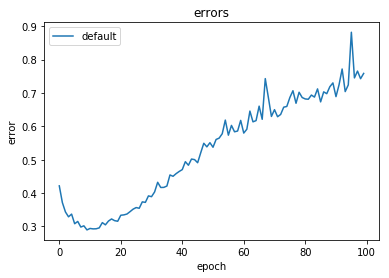

In [8]:
plot_graphs(test_log, 'loss')

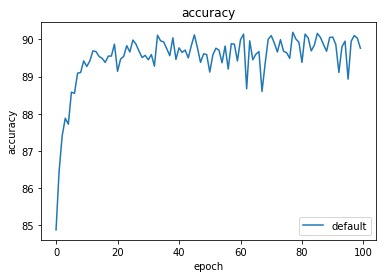

In [9]:
plot_graphs(test_log, 'accuracy')

In [ ]:
test_log